# 04 - dataset blancement

In [1]:
# Importing libraries

import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from shutil import copy2, rmtree
from scipy.ndimage import zoom
from typing import Dict, List, Tuple, Union, Optional
from pathlib import Path
import seaborn as sns

# Set Seaborn style for enhanced aesthetics
sns.set(style="whitegrid")

In [2]:
# ------ inputs ------
# Set directories
input_dir = '../data/dataset/'
output_dir = '../data/dataset_balanced/'

In [3]:
# Utils functions for >> BALANCED DATASET GENERATION <<

def get_water_percentage(dir_name: str) -> int:
    """
    Extract the water percentage from the directory name.

    Args:
        dir_name (str): The name of the directory containing water percentage information.

    Returns:
        int: The water percentage extracted from the directory name.
    """
    return int(dir_name.split('_')[2])

def load_dataset(base_dir: str) -> Dict[str, List[Tuple[str, int]]]:
    """
    Load dataset from the base directory.

    Args:
        base_dir (str): The base directory containing the dataset.

    Returns:
        Dict[str, List[Tuple[str, int]]]: A dictionary where keys are scene names and values are lists of tuples
                                          with directory names and corresponding water percentages.
    """
    dataset = {}
    for scene in os.listdir(base_dir):
        scene_path = os.path.join(base_dir, scene)
        if os.path.isdir(scene_path):
            dataset[scene] = []
            for dir_name in os.listdir(scene_path):
                water_percentage = get_water_percentage(dir_name)
                dataset[scene].append((dir_name, water_percentage))
    return dataset

def bin_dataset(dataset: Dict[str, List[Tuple[str, int]]], bin_size: int) -> Dict[str, Dict[int, List[str]]]:
    """
    Bin the dataset based on water percentage.

    Args:
        dataset (Dict[str, List[Tuple[str, int]]]): The dataset to bin.
        bin_size (int): The size of each bin for water percentage.

    Returns:
        Dict[str, Dict[int, List[str]]]: A dictionary where keys are scene names, and values are dictionaries
                                          with bin indices as keys and lists of directory names as values.
    """
    binned_dataset = {}
    for scene, dirs in dataset.items():
        binned_dataset[scene] = {}
        for dir_name, water_percentage in dirs:
            bin_index = water_percentage // bin_size
            if bin_index not in binned_dataset[scene]:
                binned_dataset[scene][bin_index] = []
            binned_dataset[scene][bin_index].append(dir_name)
    return binned_dataset

def balance_dataset(binned_dataset: Dict[str, Dict[int, List[str]]]) -> Dict[str, Dict[int, List[str]]]:
    """
    Balance the dataset by limiting the number of samples in each bin to the mean plus half the standard deviation.

    Args:
        binned_dataset (Dict[str, Dict[int, List[str]]]): The binned dataset to balance.

    Returns:
        Dict[str, Dict[int, List[str]]]: A balanced dataset with the number of samples in each bin adjusted.
    """
    balanced_dataset = {}
    for scene, bins in binned_dataset.items():
        num_members = [len(bins[bin_index]) for bin_index in bins]
        mean = np.mean(num_members)
        std = np.std(num_members)
        threshold = mean + (std / 2)
        
        balanced_dataset[scene] = {}
        for bin_index, dirs in bins.items():
            if len(dirs) > threshold:
                dirs = random.sample(dirs, int(threshold))
            balanced_dataset[scene][bin_index] = dirs
    return balanced_dataset

def apply_augmentations(data: np.ndarray, augmentation: str) -> np.ndarray:
    """
    Apply the specified augmentation to the given data.

    Args:
        data (np.ndarray): The data to augment.
        augmentation (str): The type of augmentation to apply ('hf', 'vf', 'sc', 'tr', 'ro').

    Returns:
        np.ndarray: The augmented data.
    """
    if augmentation == 'hf':
        return np.fliplr(data)
    elif augmentation == 'vf':
        return np.flipud(data)
    elif augmentation == 'sc':
        scale_factor = 1.2
        zoom_factor = (scale_factor, scale_factor)
        scaled_data = zoom(data, zoom_factor, order=1)  # Bilinear interpolation
        start_x = (scaled_data.shape[0] - 256) // 2
        start_y = (scaled_data.shape[1] - 256) // 2
        return scaled_data[start_x:start_x + 256, start_y:start_y + 256]
    elif augmentation == 'tr':
        shift = 10
        return np.roll(data, shift, axis=(0, 1))
    elif augmentation == 'ro':
        return np.rot90(data, 2)
    else:
        raise ValueError(f"Unknown augmentation type: {augmentation}")

def augment_data(scene: str, dir_name: str, input_dir: str, output_dir: str) -> None:
    """
    Augment data for a given scene and directory.

    Args:
        scene (str): The name of the scene.
        dir_name (str): The name of the directory containing the data.
        input_dir (str): The input directory containing the original data.
        output_dir (str): The output directory to save augmented data.
    """
    augmentations = ['hf', 'vf', 'sc', 'tr', 'ro']
    
    src_vv = os.path.join(input_dir, scene, dir_name, "vv.tif")
    src_hand = os.path.join(input_dir, scene, dir_name, "HAND.tif")
    src_mask = os.path.join(input_dir, scene, dir_name, "mask.tif")
    
    with rasterio.open(src_vv) as src:
        vv_data = src.read(1)
        vv_transform = src.transform
    with rasterio.open(src_hand) as src:
        hand_data = src.read(1)
        hand_transform = src.transform
    with rasterio.open(src_mask) as src:
        mask_data = src.read(1)
        mask_transform = src.transform

    for aug in augmentations:
        augmented_dir_name = f"{dir_name}_{aug}"
        aug_vv = os.path.join(output_dir, scene, augmented_dir_name, "vv.tif")
        aug_hand = os.path.join(output_dir, scene, augmented_dir_name, "HAND.tif")
        aug_mask = os.path.join(output_dir, scene, augmented_dir_name, "mask.tif")
        
        os.makedirs(os.path.join(output_dir, scene, augmented_dir_name), exist_ok=True)
        
        vv_data_aug = apply_augmentations(vv_data, aug)
        hand_data_aug = apply_augmentations(hand_data, aug)
        mask_data_aug = apply_augmentations(mask_data, aug)

        with rasterio.open(aug_vv, 'w', driver='GTiff', height=vv_data_aug.shape[0], width=vv_data_aug.shape[1], count=1, dtype=vv_data_aug.dtype, crs=src.crs, transform=vv_transform) as dst:
            dst.write(vv_data_aug, 1)
        with rasterio.open(aug_hand, 'w', driver='GTiff', height=hand_data_aug.shape[0], width=hand_data_aug.shape[1], count=1, dtype=hand_data_aug.dtype, crs=src.crs, transform=hand_transform) as dst:
            dst.write(hand_data_aug, 1)
        with rasterio.open(aug_mask, 'w', driver='GTiff', height=mask_data_aug.shape[0], width=mask_data_aug.shape[1], count=1, dtype=mask_data_aug.dtype, crs=src.crs, transform=mask_transform) as dst:
            dst.write(mask_data_aug, 1)

def create_balanced_dataset(balanced_dataset: Dict[str, Dict[int, List[str]]], input_dir: str, output_dir: str, augment: bool = True) -> None:
    """
    Create a balanced dataset directory from the given balanced dataset.

    Args:
        balanced_dataset (Dict[str, Dict[int, List[str]]]): The balanced dataset to process.
        input_dir (str): The input directory containing the original data.
        output_dir (str): The output directory to save the balanced dataset.
        augment (bool): Whether to apply augmentations to balance the dataset. Default is True.
    """
    if os.path.exists(output_dir):
        rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    all_bin_sizes = []
    for scene, bins in balanced_dataset.items():
        for bin_index, dirs in bins.items():
            all_bin_sizes.append(len(dirs))
    mean_bin_size = np.mean(all_bin_sizes)

    for scene, bins in balanced_dataset.items():
        for bin_index, dirs in bins.items():
            for dir_name in dirs:
                original_dir_name = f"{dir_name}_na"
                original_dst_dir = os.path.join(output_dir, scene, original_dir_name)
                os.makedirs(original_dst_dir, exist_ok=True)
                
                src_dir = os.path.join(input_dir, scene, dir_name)
                copy2(os.path.join(src_dir, "vv.tif"), os.path.join(original_dst_dir, "vv.tif"))
                copy2(os.path.join(src_dir, "HAND.tif"), os.path.join(original_dst_dir, "HAND.tif"))
                copy2(os.path.join(src_dir, "mask.tif"), os.path.join(original_dst_dir, "mask.tif"))

                if augment and len(dirs) < mean_bin_size:
                    augment_data(scene, dir_name, input_dir, output_dir)

def plot_sample_images(dataset: Dict[str, List[Tuple[str, int]]], input_dir: str, num_samples: int = 5) -> None:
    """
    Plot sample images from the dataset.

    Args:
        dataset (Dict[str, List[Tuple[str, int]]]): The dataset to sample images from.
        input_dir (str): The directory containing the dataset.
        num_samples (int): The number of samples to plot. Default is 5.
    """
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    scenes = list(dataset.keys())
    for i in range(num_samples):
        scene = random.choice(scenes)
        dir_name, _ = random.choice(dataset[scene])
        vv_path = os.path.join(input_dir, scene, dir_name, "vv.tif")
        hand_path = os.path.join(input_dir, scene, dir_name, "HAND.tif")
        mask_path = os.path.join(input_dir, scene, dir_name, "mask.tif")
        
        with rasterio.open(vv_path) as src:
            vv_data = src.read(1)
        with rasterio.open(hand_path) as src:
            hand_data = src.read(1)
        with rasterio.open(mask_path) as src:
            mask_data = src.read(1)

        axs[i, 0].imshow(vv_data, cmap='gray')
        axs[i, 0].set_title(f"VV Band - {scene}/{dir_name}")
        axs[i, 1].imshow(hand_data, cmap='gray')
        axs[i, 1].set_title(f"HAND - {scene}/{dir_name}")
        axs[i, 2].imshow(mask_data, cmap='gray')
        axs[i, 2].set_title(f"Mask - {scene}/{dir_name}")

    plt.tight_layout()
    plt.show()

def process_dataset(input_dir: str, output_dir: str, bin_size: int = 10) -> None:
    """
    Main function to process the dataset: load, bin, balance, and augment data, and plot sample images.

    Args:
        input_dir (str): The directory containing the original dataset.
        output_dir (str): The directory to save the balanced dataset.
        bin_size (int): The size of each bin for water percentage. Default is 10.
    """
    dataset = load_dataset(input_dir)
    
    # Plot sample images from the original dataset
    plot_sample_images(dataset, input_dir)

    binned_dataset = bin_dataset(dataset, bin_size)
    balanced_dataset = balance_dataset(binned_dataset)
    create_balanced_dataset(balanced_dataset, input_dir, output_dir)

    # Plot sample images from the balanced dataset
    balanced_dataset_loaded = load_dataset(output_dir)
    plot_sample_images(balanced_dataset_loaded, output_dir)

In [4]:
# Utils functions for >> PLOTTING AND COMPARISON << between base dataset and balanced dataset

def calculate_bin_distribution(dataset: Dict[str, List[Tuple[str, int]]], bin_size: int) -> Dict[str, Dict[int, int]]:
    """
    Calculate the distribution of water percentages into bins.

    Args:
        dataset (Dict[str, List[Tuple[str, int]]]): The dataset to be binned.
        bin_size (int): The size of each bin.

    Returns:
        Dict[str, Dict[int, int]]: A dictionary where keys are scene names and values are dictionaries with bin indices as keys and counts as values.
    """
    distribution = {}
    for scene, dirs in dataset.items():
        distribution[scene] = {}
        for _, water_percentage in dirs:
            bin_index = water_percentage // bin_size
            if bin_index not in distribution[scene]:
                distribution[scene][bin_index] = 0
            distribution[scene][bin_index] += 1
    return distribution

def create_bin_labels(bin_size: int) -> List[str]:
    """
    Create labels for bins based on bin size.

    Args:
        bin_size (int): The size of each bin.

    Returns:
        List[str]: A list of labels for the bins.
    """
    max_bin = 100 // bin_size  # Since the maximum water percentage is 100
    return [f"{i*bin_size}-{(i+1)*bin_size}" for i in range(max_bin + 1)]

def add_value_labels(ax: plt.Axes, x: List[int], y: List[int]) -> None:
    """
    Add value labels on top of bars in the bar plot.

    Args:
        ax (plt.Axes): The axes on which to add value labels.
        x (List[int]): The x coordinates of the bars.
        y (List[int]): The y coordinates of the bars.
    """
    for xi, yi in zip(x, y):
        ax.text(xi, yi, str(yi), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

def plot_bin_distribution(
    original_distribution: Dict[str, Dict[int, int]],
    augmented_distribution: Dict[str, Dict[int, int]],
    bin_size: int,
    output_dir: str
) -> None:
    """
    Plot the bin distribution comparison for each scene.

    Args:
        original_distribution (Dict[str, Dict[int, int]]): The bin distribution for the original dataset.
        augmented_distribution (Dict[str, Dict[int, int]]): The bin distribution for the augmented dataset.
        bin_size (int): The size of each bin.
        output_dir (str): The directory where the plot will be saved.
    """
    scenes = [scene for scene in original_distribution.keys() if scene in augmented_distribution.keys()]
    num_scenes = len(scenes)
    
    fig, axs = plt.subplots(num_scenes, 2, figsize=(15, num_scenes * 5))
    
    # Create a color palette
    colors = sns.color_palette("pastel")
    
    for i, scene in enumerate(scenes):
        orig_bins = original_distribution[scene]
        aug_bins = augmented_distribution[scene]
        
        orig_bins_sorted = sorted(orig_bins.items())
        aug_bins_sorted = sorted(aug_bins.items())
        
        orig_x, orig_y = zip(*orig_bins_sorted) if orig_bins_sorted else ([], [])
        aug_x, aug_y = zip(*aug_bins_sorted) if aug_bins_sorted else ([], [])
        
        max_bin = max(orig_x + aug_x)  # Determine the maximum bin index
        bin_labels = create_bin_labels(bin_size)
        
        # Plot original distribution
        axs[i, 0].bar(orig_x, orig_y, color=colors[0], alpha=0.8, edgecolor='black')
        axs[i, 0].set_title(f"Original Bin Distribution - {scene}", fontsize=14, fontweight='bold')
        axs[i, 0].set_xlabel(f"Water Percentage Bins (Bin Size = {bin_size})", fontsize=12)
        axs[i, 0].set_ylabel("Number of Directories", fontsize=12)
        axs[i, 0].set_xticks(orig_x)
        axs[i, 0].set_xticklabels([bin_labels[int(x)] for x in orig_x], rotation=45, ha='right')
        add_value_labels(axs[i, 0], orig_x, orig_y)  # Add value labels
        
        # Plot augmented distribution
        axs[i, 1].bar(aug_x, aug_y, color=colors[1], alpha=0.8, edgecolor='black')
        axs[i, 1].set_title(f"Augmented Bin Distribution - {scene}", fontsize=14, fontweight='bold')
        axs[i, 1].set_xlabel(f"Water Percentage Bins (Bin Size = {bin_size})", fontsize=12)
        axs[i, 1].set_ylabel("Number of Directories", fontsize=12)
        axs[i, 1].set_xticks(aug_x)
        axs[i, 1].set_xticklabels([bin_labels[int(x)] for x in aug_x], rotation=45, ha='right')
        add_value_labels(axs[i, 1], aug_x, aug_y)  # Add value labels
        
        # Calculate and display the sum of all bins
        orig_sum = sum(orig_y)
        aug_sum = sum(aug_y)
        
        # Add a text box with the sums for original
        textstr_orig = f'Original Total: {orig_sum}'
        props_orig = dict(boxstyle='round', facecolor='white', edgecolor='black')
        axs[i, 0].text(0.95, 0.95, textstr_orig, transform=axs[i, 0].transAxes, fontsize=14,
                       verticalalignment='top', horizontalalignment='right', bbox=props_orig)
        
        # Add a text box with the sums for augmented
        textstr_aug = f'Augmented Total: {aug_sum}'
        props_aug = dict(boxstyle='round', facecolor='white', edgecolor='black')
        axs[i, 1].text(0.95, 0.95, textstr_aug, transform=axs[i, 1].transAxes, fontsize=14,
                       verticalalignment='top', horizontalalignment='right', bbox=props_aug)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "bin_distribution_comparison_per_scene.png"))
    plt.show()

def plot_overall_distribution(
    original_distribution: Dict[str, Dict[int, int]],
    augmented_distribution: Dict[str, Dict[int, int]],
    bin_size: int,
    output_dir: str
) -> None:
    """
    Plot the overall dataset distribution comparison.

    Args:
        original_distribution (Dict[str, Dict[int, int]]): The bin distribution for the original dataset.
        augmented_distribution (Dict[str, Dict[int, int]]): The bin distribution for the augmented dataset.
        bin_size (int): The size of each bin.
        output_dir (str): The directory where the plot will be saved.
    """
    orig_bins_combined = {}
    aug_bins_combined = {}
    
    for scene, bins in original_distribution.items():
        for bin_index, count in bins.items():
            if bin_index not in orig_bins_combined:
                orig_bins_combined[bin_index] = 0
            orig_bins_combined[bin_index] += count
            
    for scene, bins in augmented_distribution.items():
        for bin_index, count in bins.items():
            if bin_index not in aug_bins_combined:
                aug_bins_combined[bin_index] = 0
            aug_bins_combined[bin_index] += count
    
    orig_bins_sorted = sorted(orig_bins_combined.items())
    aug_bins_sorted = sorted(aug_bins_combined.items())
    
    orig_x, orig_y = zip(*orig_bins_sorted) if orig_bins_sorted else ([], [])
    aug_x, aug_y = zip(*aug_bins_sorted) if aug_bins_sorted else ([], [])
    
    max_bin = max(orig_x + aug_x)  # Determine the maximum bin index
    bin_labels = create_bin_labels(bin_size)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    width = 0.35  # width of the bars
    
    # Create a color palette
    colors = sns.color_palette("pastel")
    
    ax.bar(orig_x, orig_y, width=width, color=colors[0], alpha=0.8, edgecolor='black', label='Original Dataset', align='center')
    ax.bar([x + width for x in aug_x], aug_y, width=width, color=colors[1], alpha=0.8, edgecolor='black', label='Balanced Dataset', align='center')
    
    ax.set_title("Overall Dataset Bin Distribution Comparison", fontsize=16, fontweight='bold')
    ax.set_xlabel(f"Water Percentage Bins (Bin Size = {bin_size})", fontsize=14)
    ax.set_ylabel("Number of Directories", fontsize=14)
    ax.legend()
    ax.set_xticks([x + width / 2 for x in orig_x])
    ax.set_xticklabels([bin_labels[int(x)] for x in orig_x], rotation=45, ha='right')
    
    # Add value labels
    add_value_labels(ax, orig_x, orig_y)  # Add value labels for the original dataset
    add_value_labels(ax, [x + width for x in aug_x], aug_y)  # Add value labels for the balanced dataset
    
    # Calculate and display the sum of all bins
    orig_sum = sum(orig_y)
    aug_sum = sum(aug_y)
    
    # Add a text box with the sums
    textstr = f'Original Total: {orig_sum}\nAugmented Total: {aug_sum}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "overall_bin_distribution_comparison.png"))
    plt.show()

def process_and_plot_distributions(
    input_dir: str,
    output_dir: str,
    bin_size: int = 10
) -> None:
    """
    Process the dataset and plot various distributions.

    Args:
        input_dir (str): The directory containing the original dataset.
        output_dir (str): The directory containing the balanced dataset and where plots will be saved.
        bin_size (int, optional): The size of each bin. Defaults to 10.
    """
    # Load original dataset
    original_dataset = load_dataset(input_dir)
    
    # Bin original dataset
    original_distribution = calculate_bin_distribution(original_dataset, bin_size)
    
    # Load balanced dataset
    balanced_dataset = load_dataset(output_dir)
    
    # Bin balanced dataset
    balanced_distribution = calculate_bin_distribution(balanced_dataset, bin_size)
    
    # Plot bin distribution for each scene
    plot_bin_distribution(original_distribution, balanced_distribution, bin_size, output_dir)
    
    # Plot overall dataset distribution
    plot_overall_distribution(original_distribution, balanced_distribution, bin_size, output_dir)


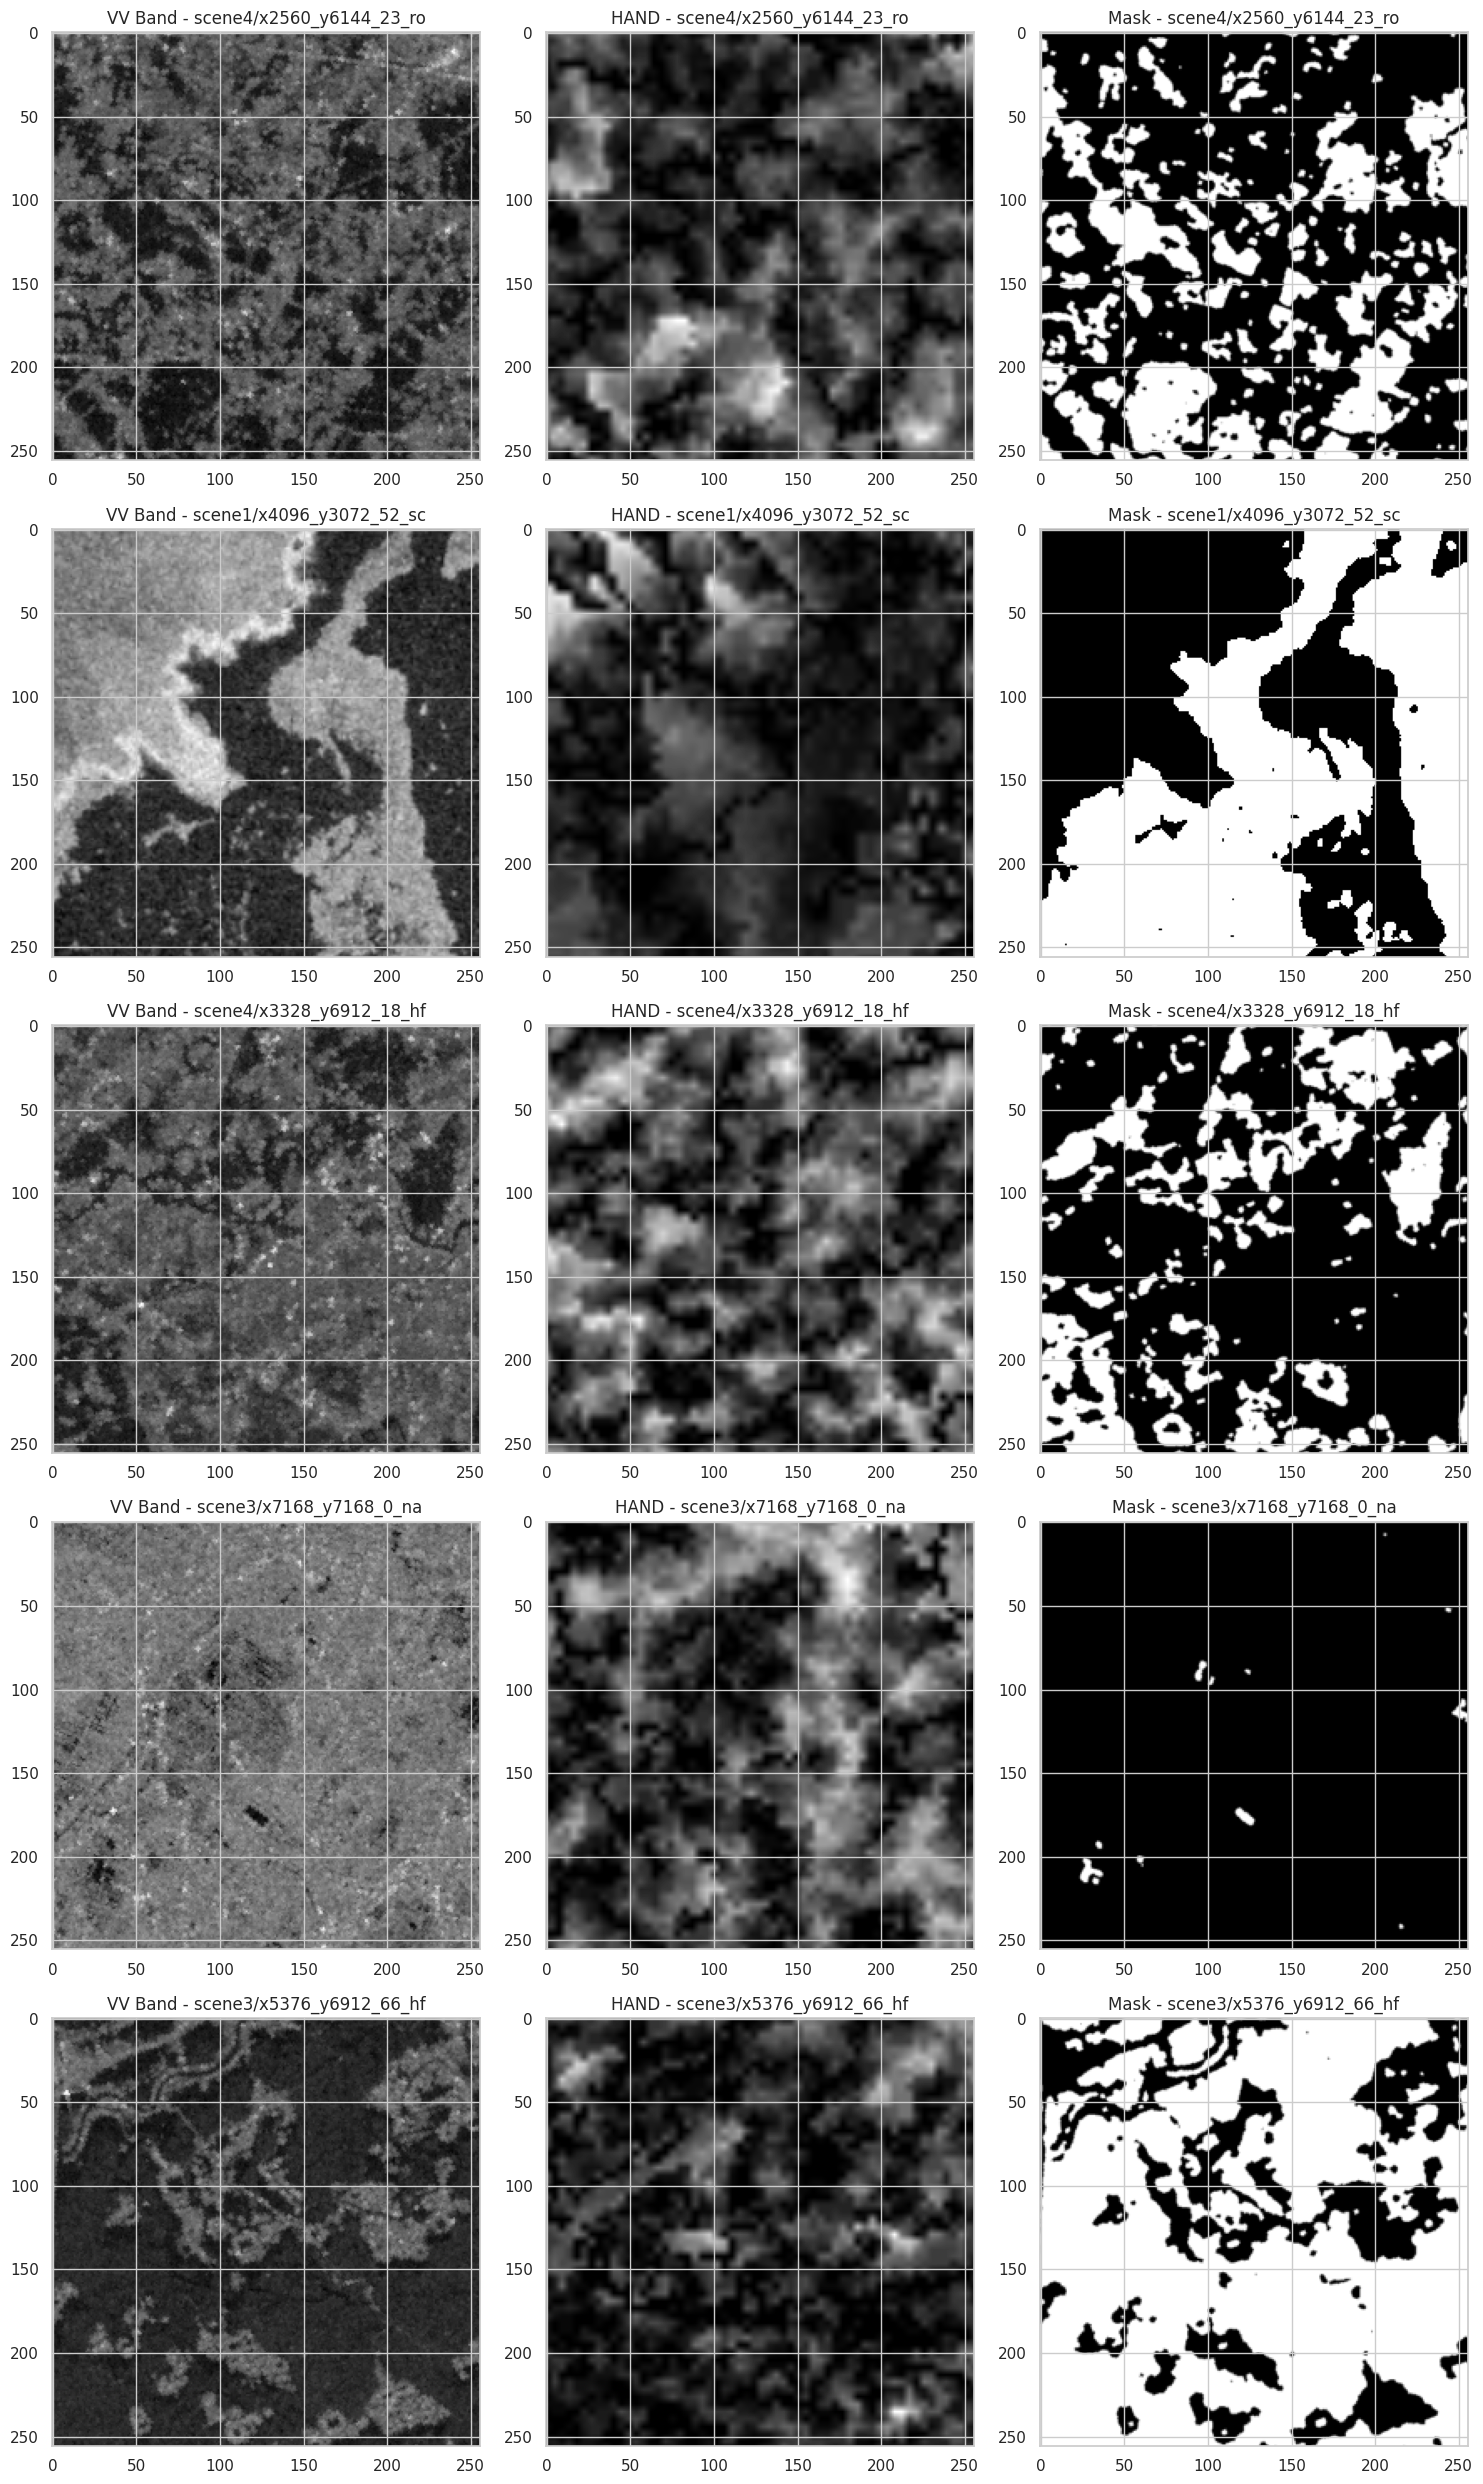

In [5]:
# GENERATING THE BALANCED DATASET

process_dataset(input_dir, output_dir)

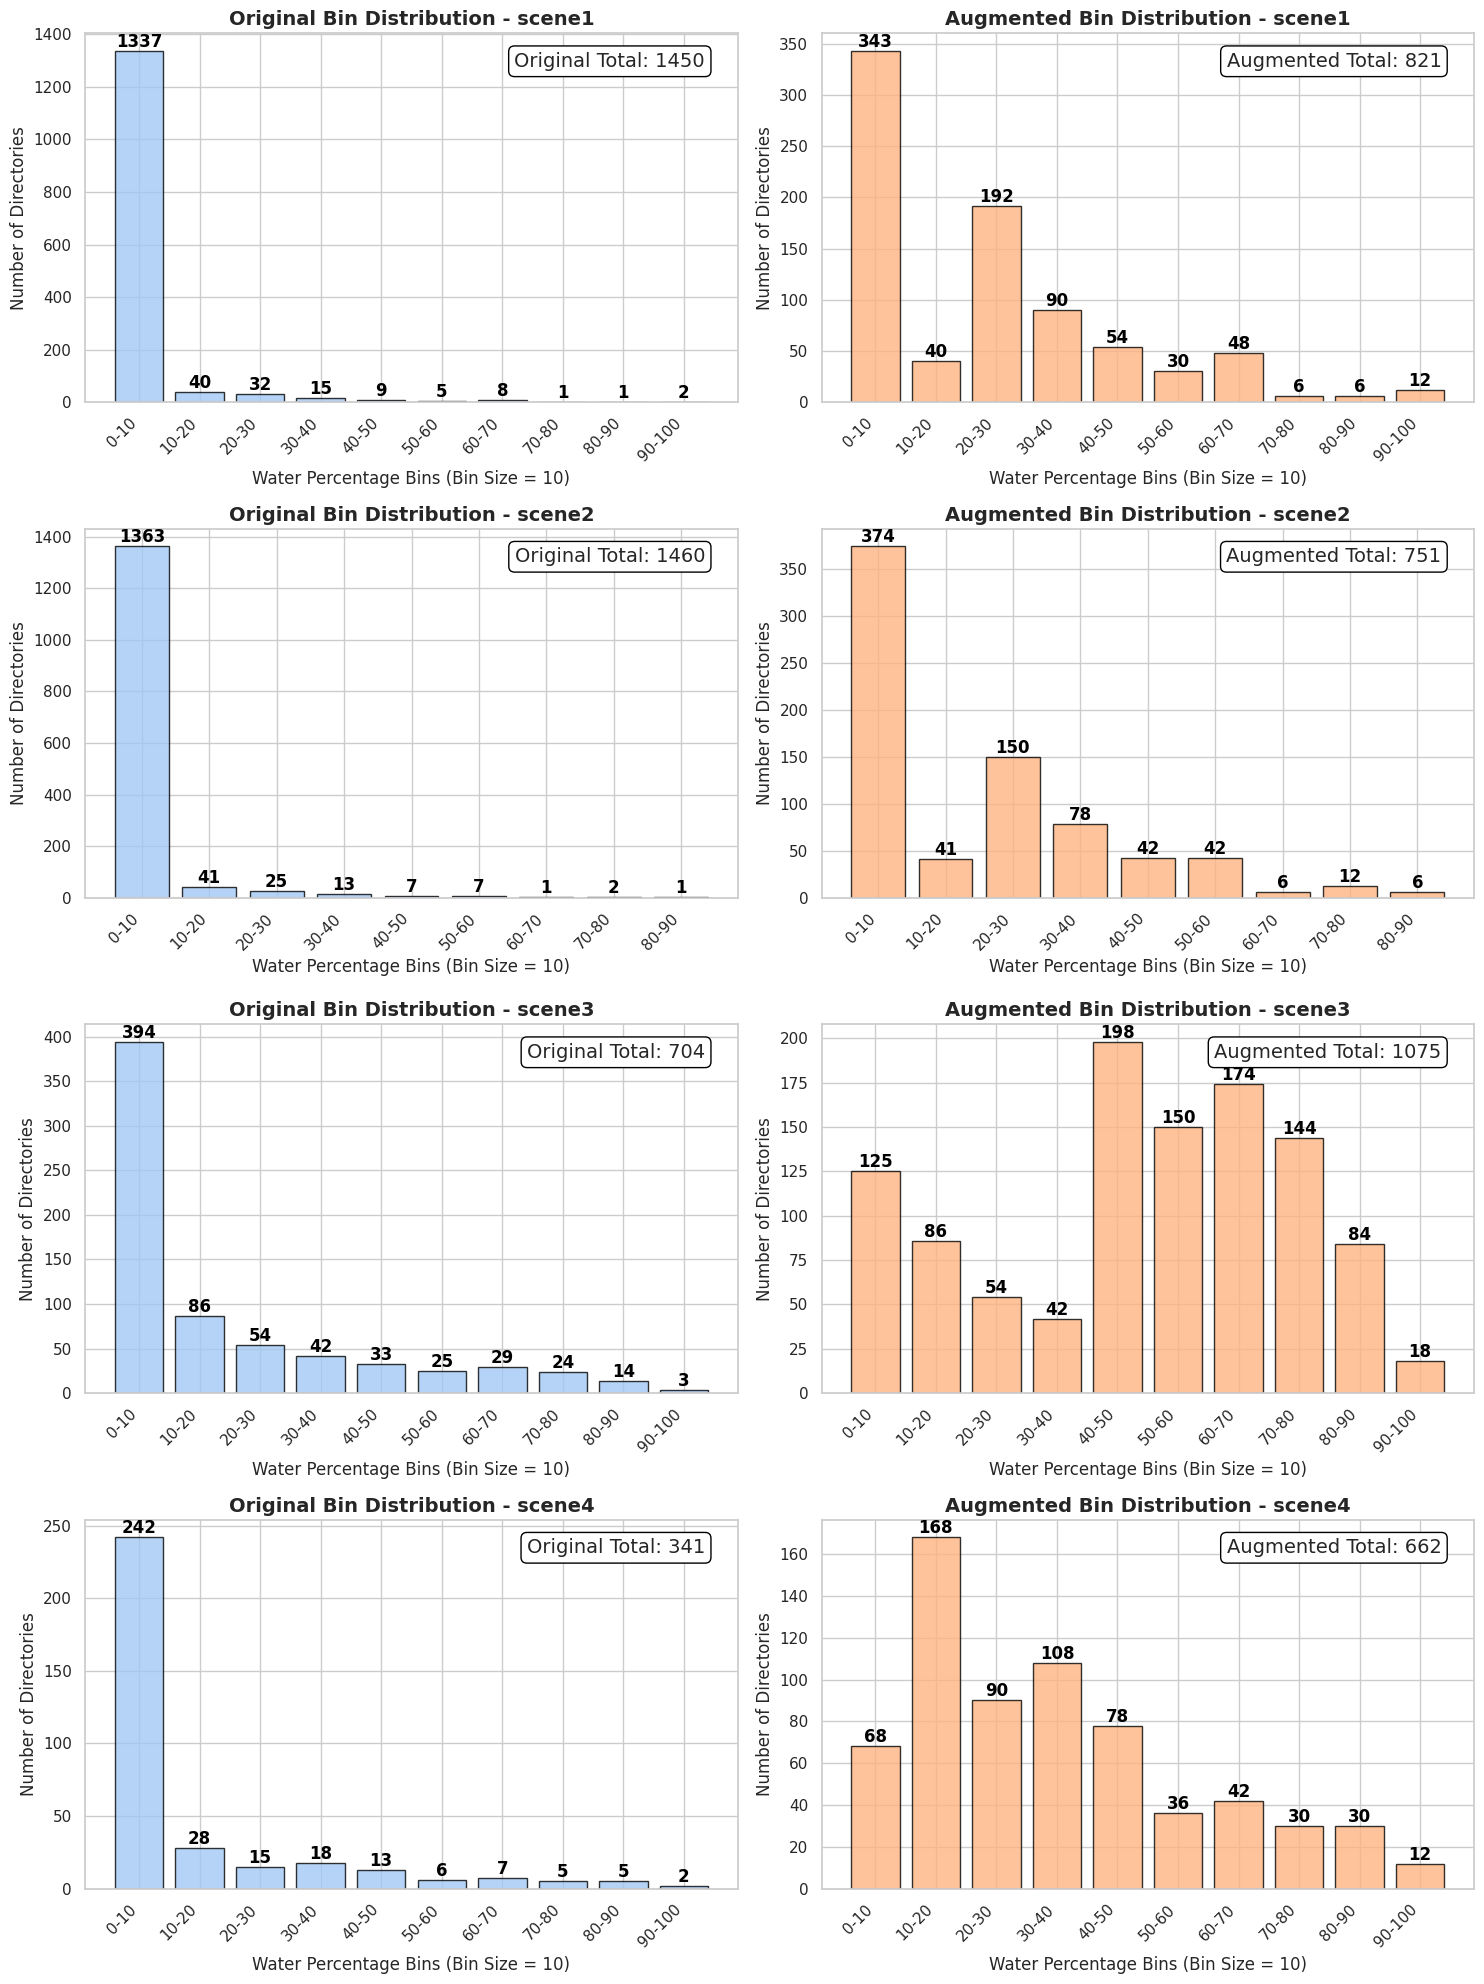

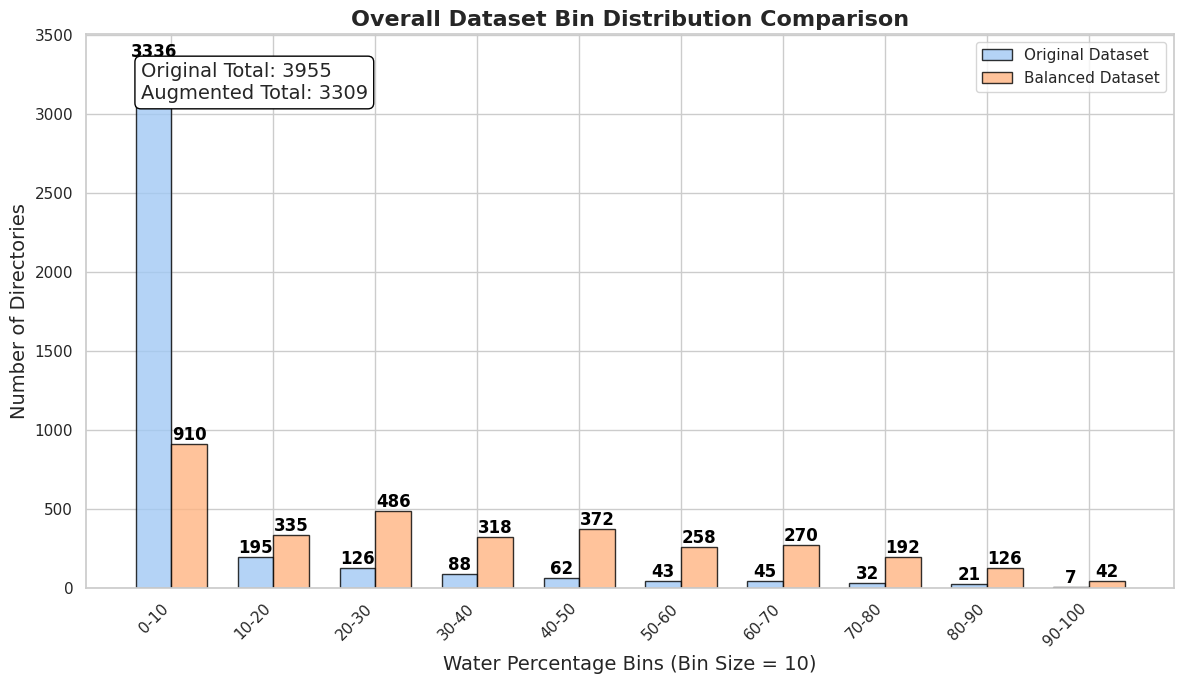

In [6]:
# PLOTTING THE RESULTS AND DISTRIBUTIONS

process_and_plot_distributions(input_dir, output_dir)